In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from collections import Counter
from datetime import datetime
import time
from tqdm import tqdm

In [19]:
def build_user_graph(graph, data, add_attributes=False, directed=True):
    pr_id_list = data['number'].unique()
    for pr_id in tqdm(pr_id_list):
        pr_owner_set, reviewer_set = extract_node_ids(pr_id, data)

        # Owner node
        for pr_owner_id in pr_owner_set:
            if not graph.has_node(pr_owner_id):
                #user_metadata = extract_metadata(pr_owner_id, data) if add_attributes else {}
                graph.add_node(pr_owner_id, is_user=True) #, **user_metadata)

            # Reviewer node
            for reviewer_id in reviewer_set:
                if not graph.has_node(reviewer_id):
                    user_metadata = extract_metadata(reviewer_id, data) if add_attributes else {}
                    graph.add_node(reviewer_id, is_user=True) #, **user_metadata)
                
                if not graph.has_edge(pr_owner_id, reviewer_id):
                    if directed:
                        weight = get_edge_weight(pr_owner_id, reviewer_id, data)
                    else:
                        weight = get_edge_weight(pr_owner_id, reviewer_id, data)
                    graph.add_edge(pr_owner_id, reviewer_id, weight=weight)

    return graph

def get_num_comments(owner, commenter, data):
    comments = data[(data['commenter_id']==commenter) & \
        ((data['head_commit_author_id']==owner)|(data['base_commit_committer_id']==owner))]
    num_comments = len(comments)
    return num_comments  

def get_edge_weight(pr_owner_id, reviewer_id, data):
    df = data[(data['commenter_id']==reviewer_id) & data['user_id'] == pr_owner_id]
    
    comment_times = df['comment_created_at'].map(convert_to_tic)
    df['weight'] = comment_times
    df = df.sort_values(by='weight')

    decay = 0.8
    counts = Counter()
    for index, row in df.iterrows():
        row['weight'] *= decay**counts[(row['number'], row['commenter_id'])]
        counts[(row['number'], row['commenter_id'])] += 1

    weight = df['weight'].sum()
    return weight

def extract_node_ids(pr_id, data):
    # Extract PR owner and metadata
    pr_df = data.loc[data.number == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    pr_owner_set = set(pr_df.user_id)
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def extract_metadata(target, data):
    metadata_cols = ['commenter_username', 'commenter_follower_count',
                    'commenter_total_github_commit_count', 'commenter_base_repo_commit_count']
    metadata_dict = data.loc[(data.commenter_id == target), metadata_cols].iloc[0].to_dict()
    return metadata_dict

def convert_to_tic(s):
    #Jan, 1, 2014
    start_time = time.mktime(datetime(2014, 1, 1).timetuple())
    #Jan, 1, 2019
    end_time = time.mktime(datetime(2019, 1, 1).timetuple())
    time_delta = end_time-start_time
    return float(time.mktime(pd.to_datetime(s).timetuple()) - start_time) / time_delta


In [7]:
df = pd.read_csv('comments_kubernetes.csv')

In [20]:
earec = nx.DiGraph()
earec = build_user_graph(earec, df)

100%|██████████| 57010/57010 [15:08<00:00, 62.76it/s]


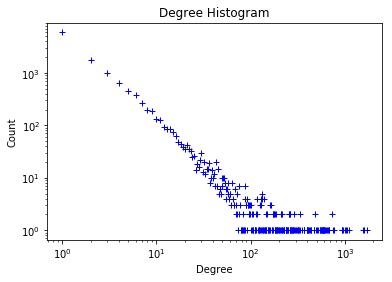

In [21]:
degree_sequence = sorted([d for n, d in earec.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.plot(deg, cnt, '+', color='b')
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.savefig("degree_hist.png", format="PNG")

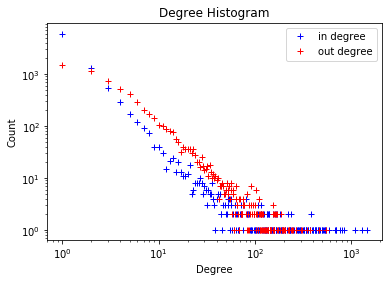

In [22]:
degree_sequence = sorted([d for n, d in earec.in_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_in, cnt_in = zip(*degreeCount.items())

degree_sequence = sorted([d for n, d in earec.out_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_out, cnt_out = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.plot(deg_in, cnt_in, '+', color='b', label='in degree')
plt.plot(deg_out, cnt_out, '+', color='r', label='out degree')
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.legend()
plt.savefig("dir_degree_hist.png", format="PNG")

In [25]:
print('Nodes', len(earec.nodes()))
print('Edges', len(earec.edges()))

('Nodes', 12775)
('Edges', 63679)
